In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime
import logging
from logging import handlers
from fetch_data import (
    static_population_erva_age,
)
from forward_integration import forward_integration
mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
# Contact matrix
c_gh_3 = np.array(([[1.3,0.31,0.23,1.07,0.51,0.16,0.14,0.09],
[0.28,1.39,0.21,0.16,0.87,0.44,0.05,0.04],
[0.19,0.19,0.83,0.26,0.25,0.42,0.18,0.06],
[0.85,0.14,0.25,0.89,0.33,0.31,0.24,0.12],
[0.43,0.8,0.26,0.36,0.72,0.49,0.24,0.17],
[0.12,0.37,0.39,0.3,0.44,0.79,0.25,0.16],
[0.11,0.04,0.17,0.24,0.22,0.25,0.59,0.28],
[0.06,0.03,0.05,0.1,0.13,0.13,0.23,0.55]]))

logger = logging.getLogger()
erva_pop_file = 'stats/erva_population_age_2020.csv'
number_age_groups = 8
num_ervas = 5
pop_ervas_age, _ = static_population_erva_age(logger, erva_pop_file,
                                              number_age_groups=number_age_groups)
pop_ervas_age = pop_ervas_age[~pop_ervas_age['erva'].str.contains('All')]
pop_ervas_age = pop_ervas_age[~pop_ervas_age['erva'].str.contains('land')]
pop_ervas_age = pop_ervas_age.sort_values(['erva', 'age_group'])
pop_ervas_npy = pop_ervas_age['Total'].values
pop_ervas_npy = pop_ervas_npy.reshape(num_ervas, number_age_groups)

ervas_order = ['HYKS', 'TYKS', 'TAYS', 'KYS', 'OYS']
ervas_df = list(pd.unique(pop_ervas_age['erva']))
ervas_pd_order = [ervas_df.index(erva) for erva in ervas_order]
# Rearrange rows in the correct order
age_er = pop_ervas_npy[ervas_pd_order, :]

pop_erva = age_er.sum(axis=1)

# Mobility matrix
m_av = np.array(
            [[1389016, 7688, 16710, 7789, 1774],
            [11316, 518173, 14139, 562, 2870],
            [22928, 12404, 511506, 4360, 1675],
            [8990, 365, 4557, 459867, 3286],
            [1798, 2417, 1592, 3360, 407636]]
       )

m_av = m_av/pop_erva[:, np.newaxis]

N_p = 5
Ng = 8
mob_av = np.zeros((N_p, N_p))
r = 1./3.
for k in range(N_p):
    for m in range(N_p):
        if k == m:
            mob_av[k,m] = (1.-r) + r*m_av[k,m]
        else:
            mob_av[k,m] = r*m_av[k,m]

####################################################################
# Equation (3) in overleaf (change in population size because of mobility) N_hat_{lg}, N_hat_{l}
pop_erva_hat = np.zeros(N_p)
age_er_hat = np.zeros((Ng, N_p))

for m in range(N_p):
    m_k = 0.0
    for k in range(N_p):
        m_k = m_k + pop_erva[k]*mob_av[k,m]
        for g in range(Ng):
            age_er_hat[g, m] = sum(age_er[:, g]*mob_av[:, m])

    pop_erva_hat[m] = m_k

##############################################
# Population size per age group in all ervas
age_pop = sum(age_er)

# Computing beta_gh for force of infection ()
beta_gh = np.zeros((Ng, Ng))

for g in range(Ng):
    for h in range(Ng):
        if g == h:
            for m in range(N_p):
                sum_kg2 = 0.0
                for k in range(N_p):
                    sum_kg2 = sum_kg2 + age_er[k, g]*mob_av[k, m]*mob_av[k, m]/pop_erva_hat[m]
            sum_kg = sum(age_er_hat[g, :]*age_er_hat[h, :]/pop_erva_hat)
            beta_gh[g, h] = age_pop[g]*c_gh_3[g, h]/(sum_kg-sum_kg2)
        else:
            sum_kg = age_er_hat[g, :]*age_er_hat[h, :]
            beta_gh[g, h] = age_pop[g]*c_gh_3[g, h]/(sum(sum_kg/pop_erva_hat))

######################################################################################
# number of ervas
N_p = 5
# number of age groups
Ng = 8
# number of optimization variables
N_f = (Ng-3)*N_p

In [3]:
T = 90
# transmission parameter
beta = 0.02
u = 30000
plot_interval = 15
t0 = '2021-04-19'
ervas_labels = ['HYKS', 'TYKS', 'TAYS', 'KYS', 'OYS']
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
policy_thl = False

Sg, Svg, Sxg, Lg, D_d, D_g, u_g = forward_integration(u, mob_av, beta, beta_gh, T, pop_erva_hat, age_er, t0, policy_thl)

age_er_prop = age_er.T
age_er_prop = age_er_prop[:, :, np.newaxis]
D_g_plot = D_g*age_er_prop
u_g_plot = u_g*age_er_prop

In [4]:
def plot_ervas(ax, D_g, t0, T, ervas_labels):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    
    num_ages, num_ervas, days = D_g.shape
    assert num_ervas == len(ervas_labels)
    
    x = [begin + datetime.timedelta(days=day) for day in range(T)]
    deaths = D_g.sum(axis=0)
    assert deaths.shape[0] == num_ervas
    assert deaths.shape[1] == T
    
    for erva_i in range(num_ervas):
        ax.plot(x, deaths[erva_i, :], label=ervas_labels[erva_i])
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of deaths')
    ax.set_title('Number of deaths per ERVA')
        
    ax.legend()

In [5]:
def plot_age_groups(ax, D_g, t0, T, age_labels):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    
    num_ages, num_ervas, days = D_g.shape
    assert num_ages == len(age_labels)
    
    x = [begin + datetime.timedelta(days=day) for day in range(T)]
    deaths = D_g.sum(axis=1)
    assert deaths.shape[0] == num_ages
    assert deaths.shape[1] == T
    
    for age_i in range(num_ages):
        ax.plot(x, deaths[age_i, :], label=age_labels[age_i])
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of deaths')
    ax.set_title('Number of deaths per age group')
        
    ax.legend()

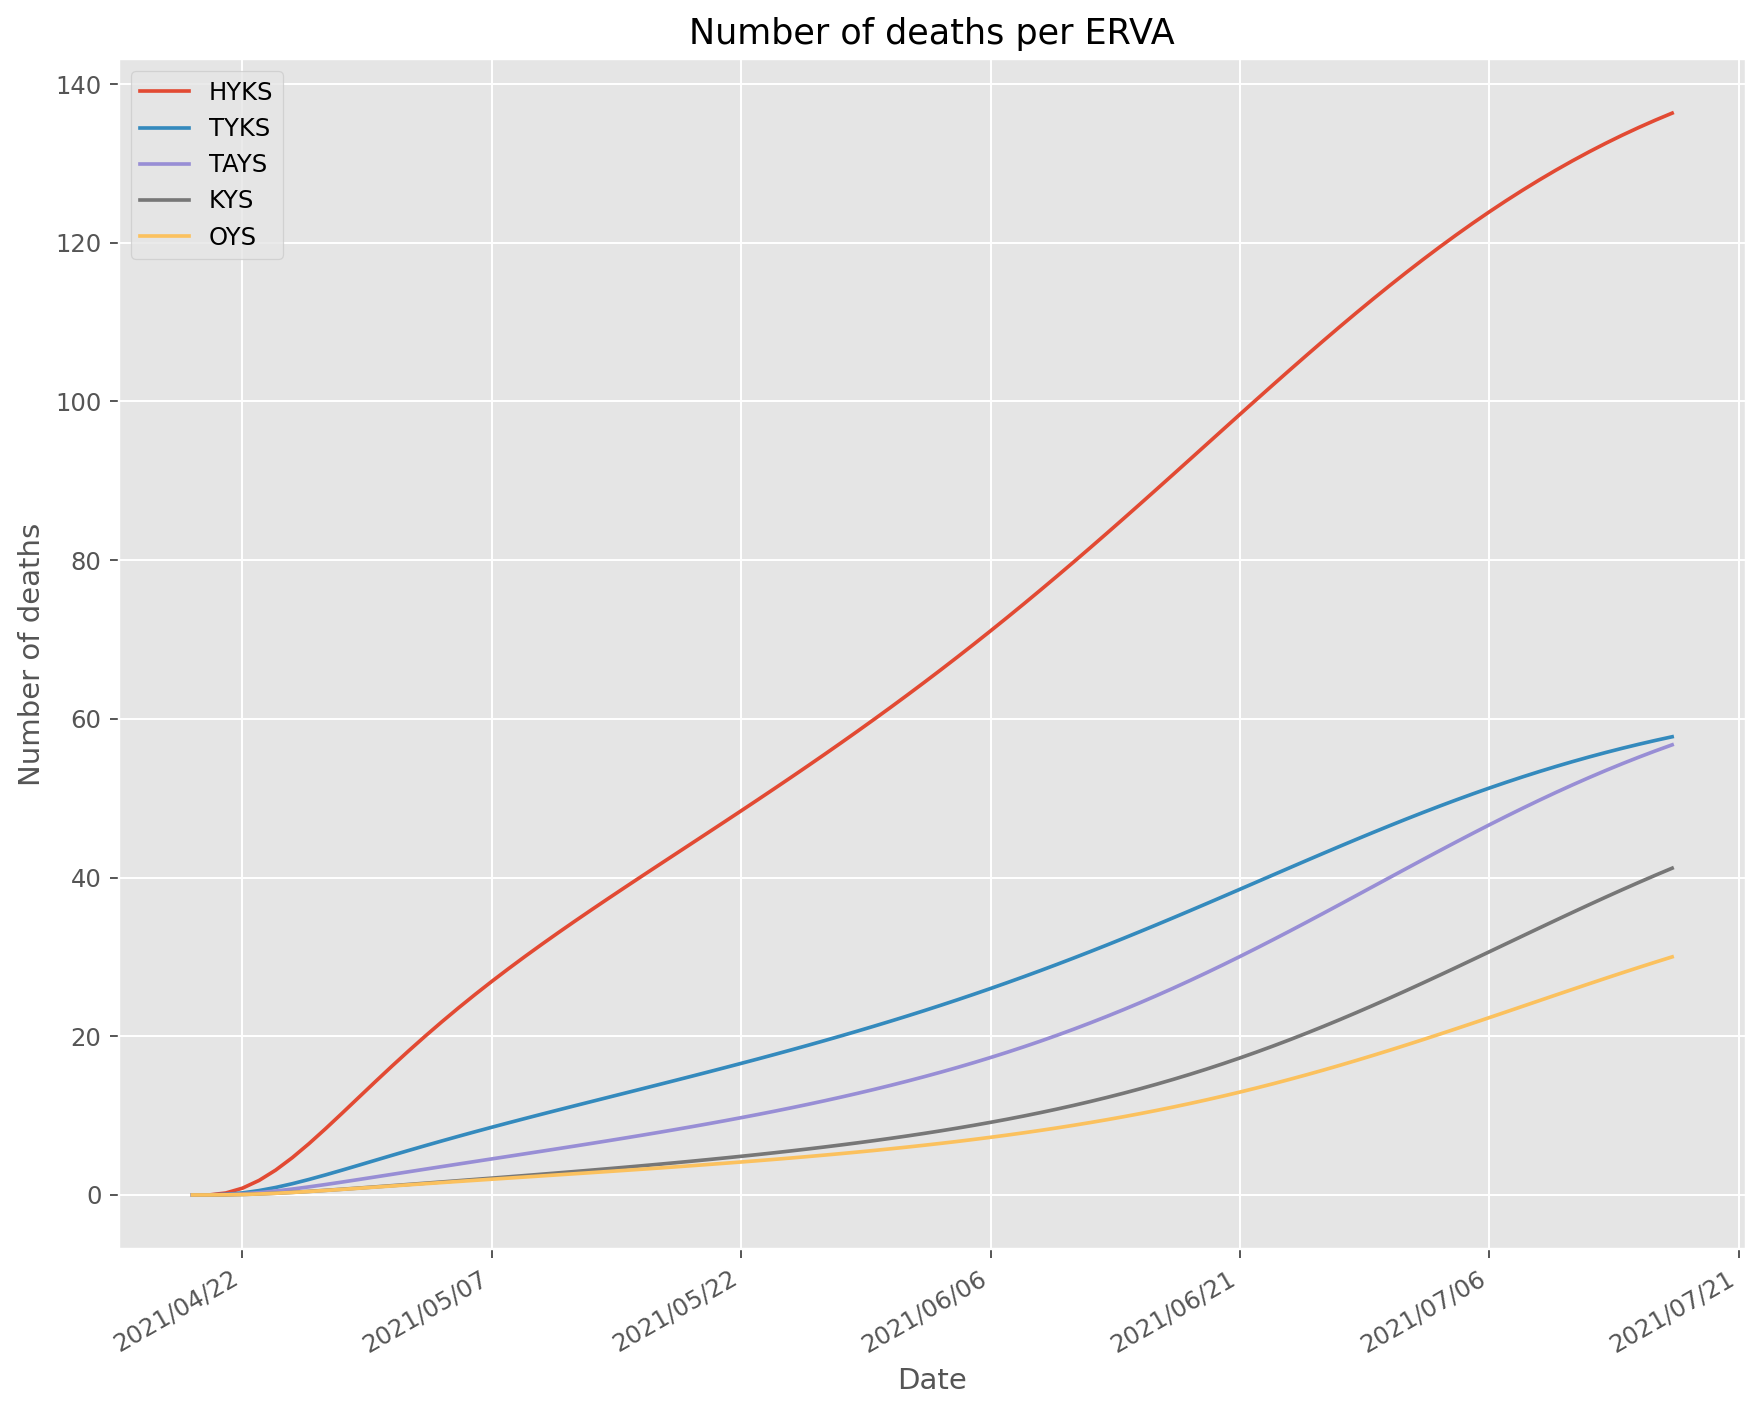

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=D_g_plot, t0=t0, T=T, ervas_labels=ervas_labels)

fig.autofmt_xdate()

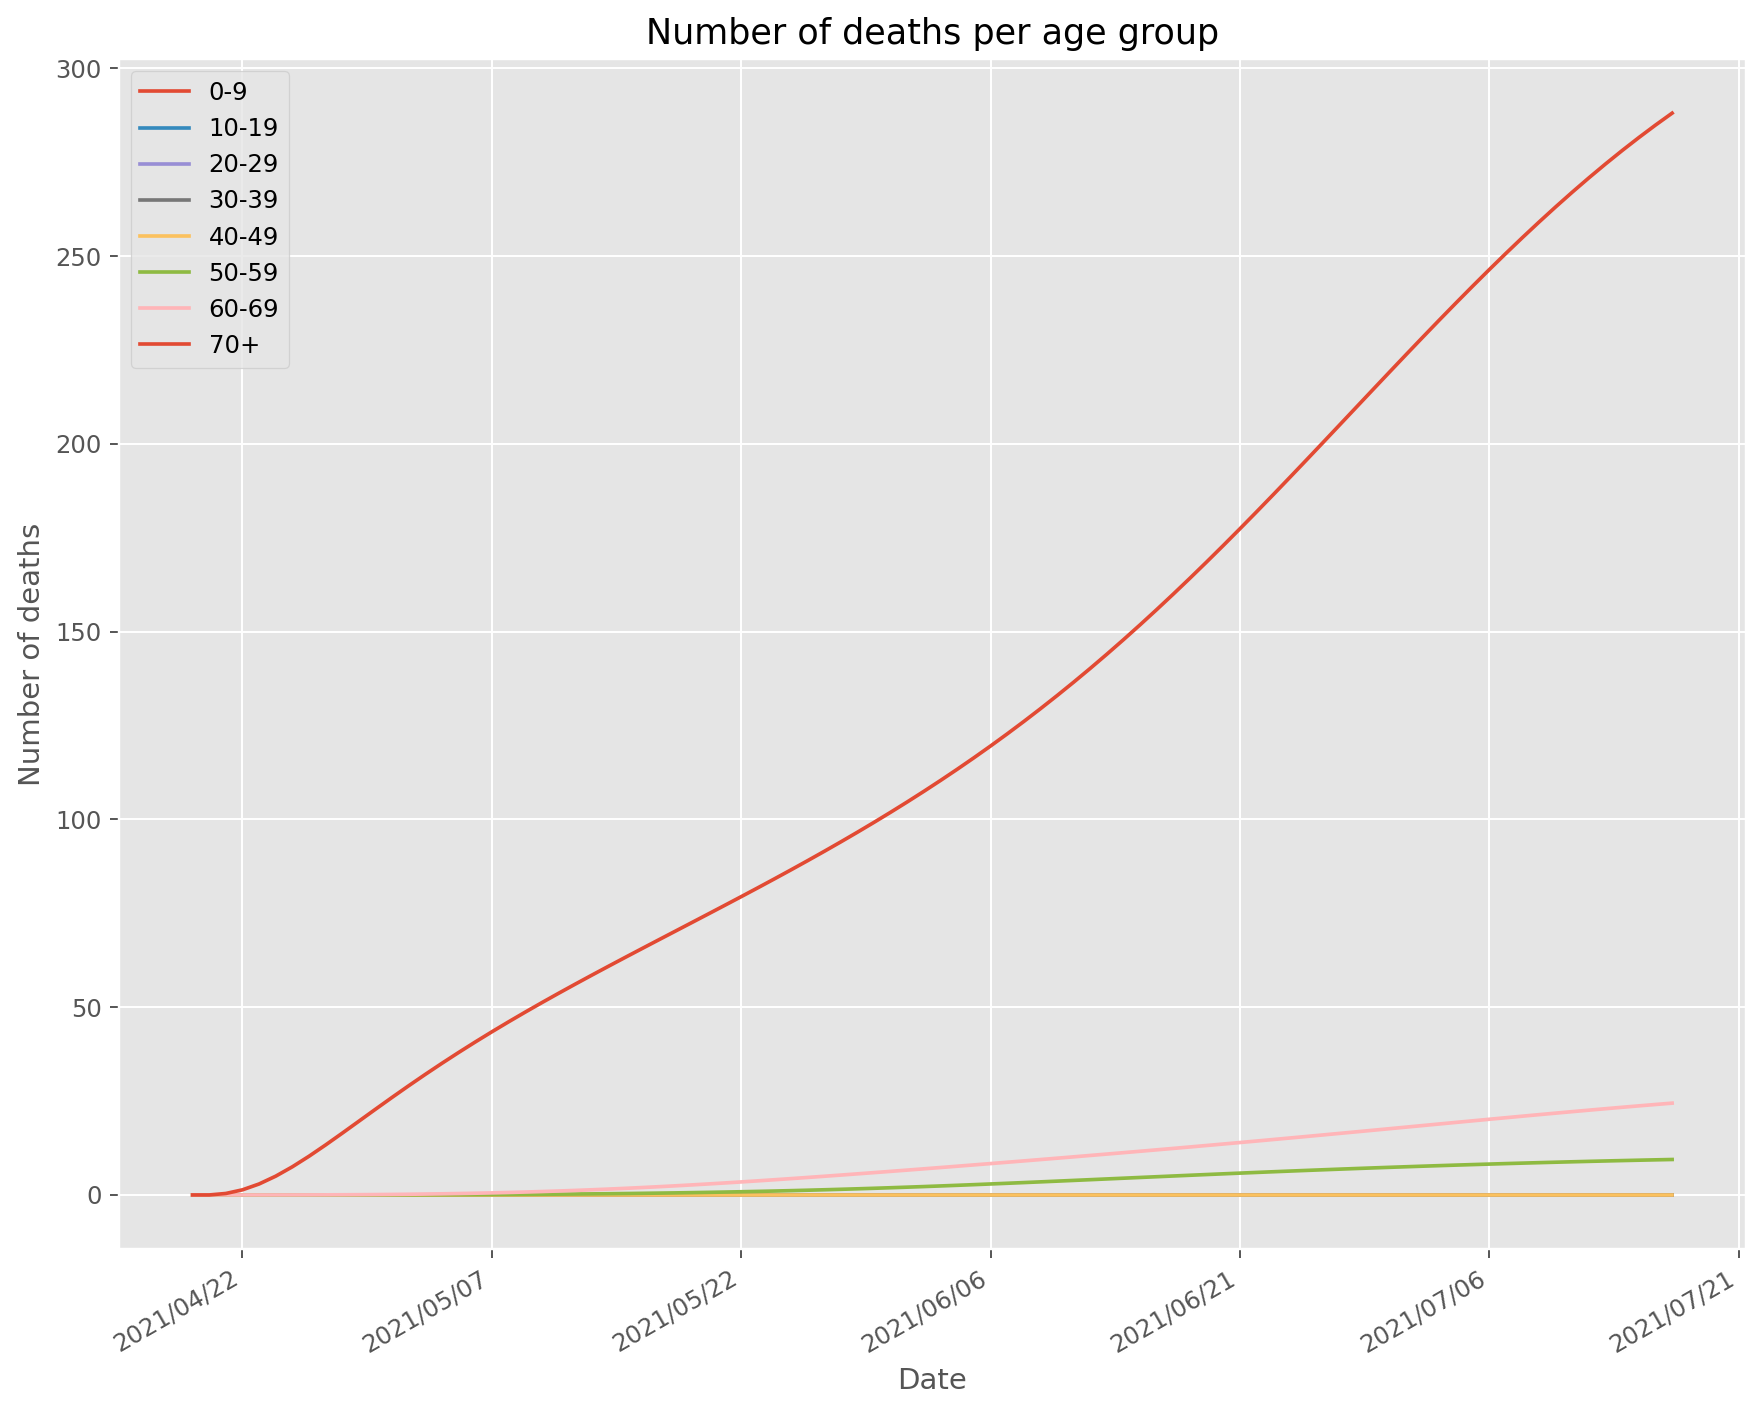

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=D_g_plot, t0=t0, T=T, age_labels=age_labels)

fig.autofmt_xdate()

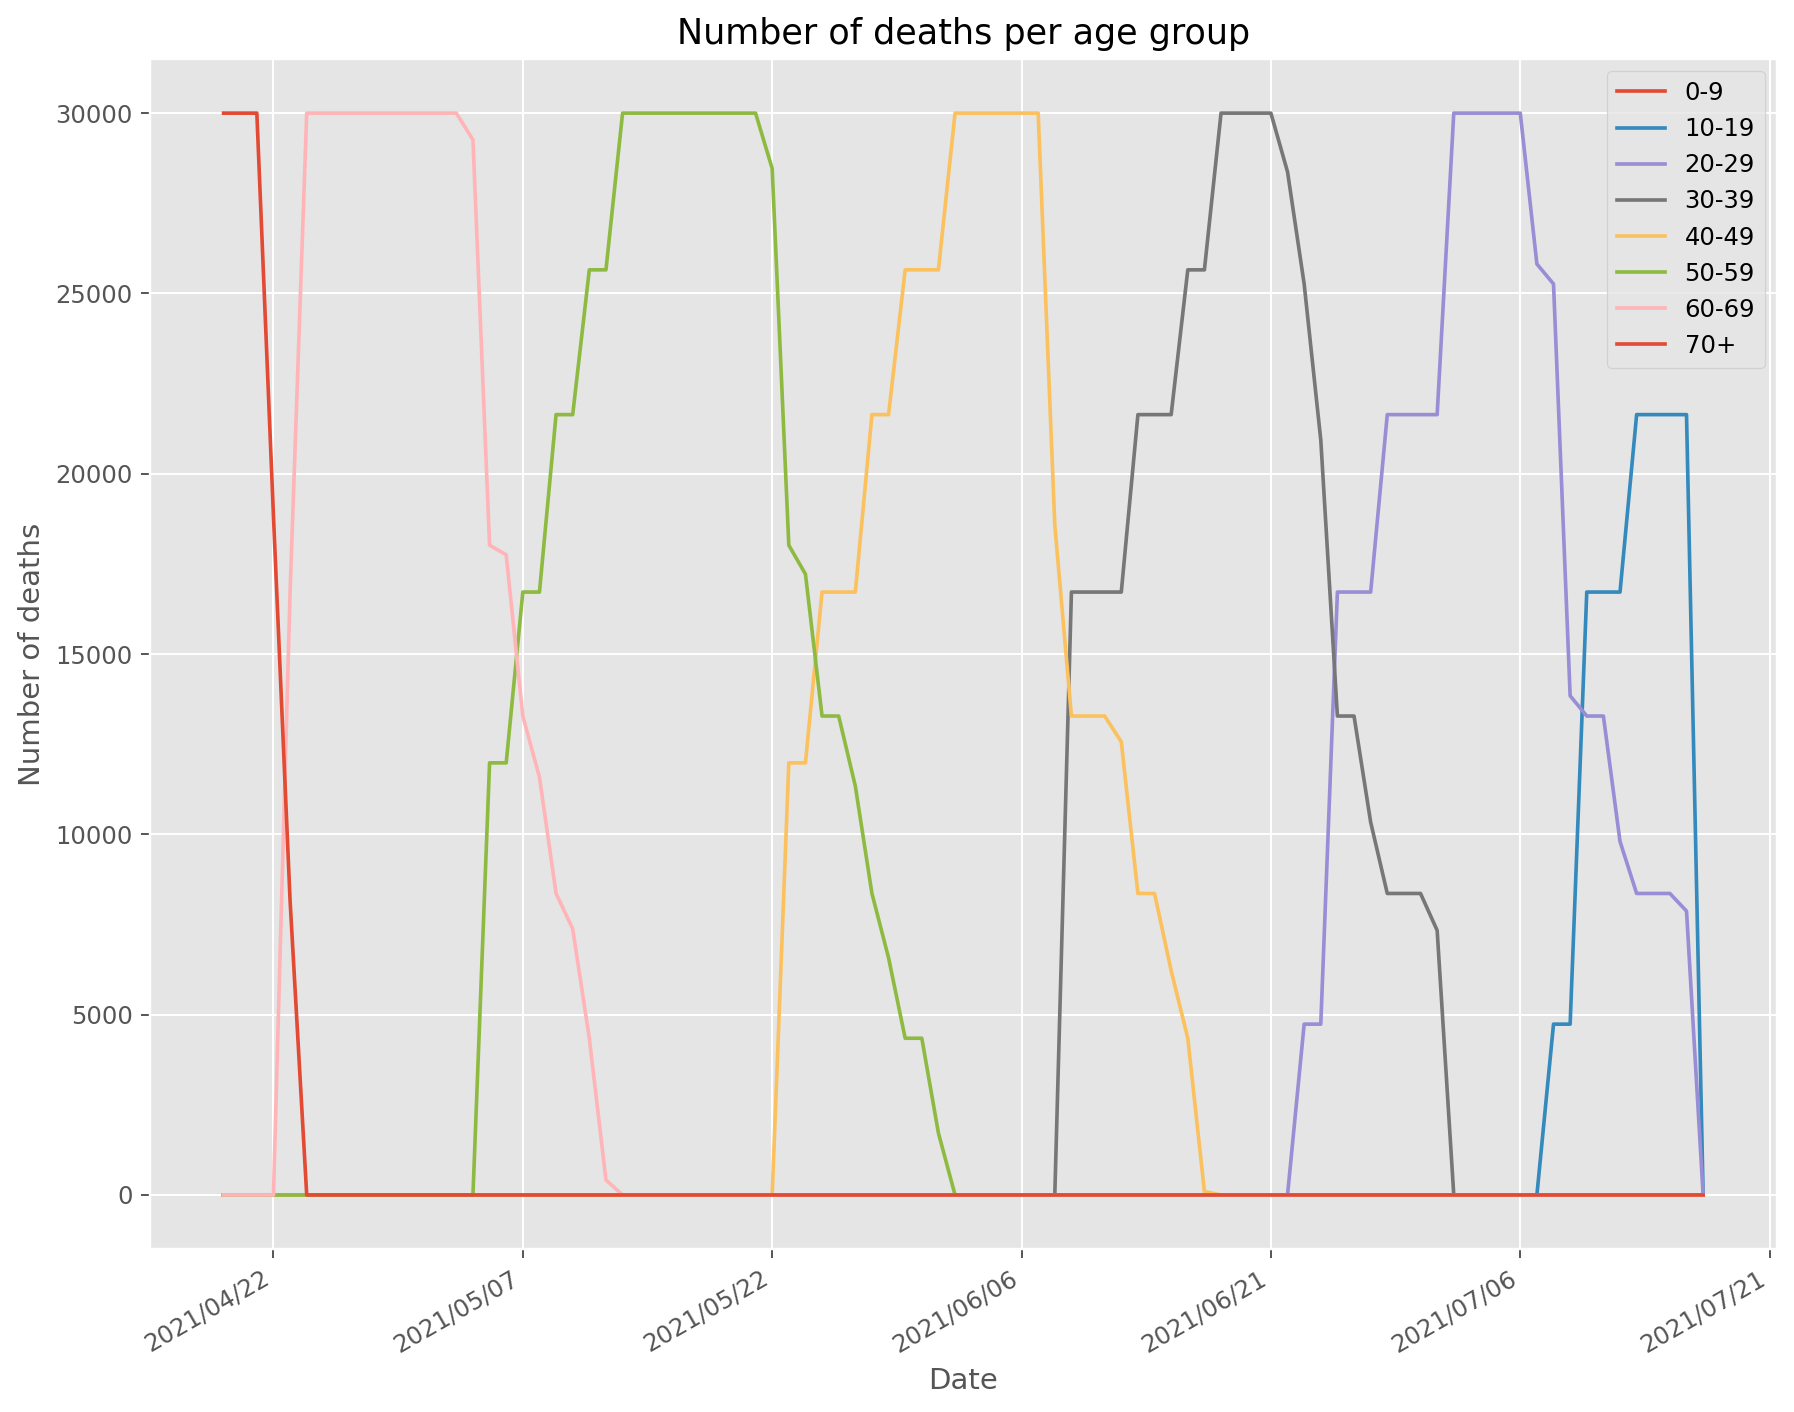

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=u_g_plot, t0=t0, T=T, age_labels=age_labels)

fig.autofmt_xdate()

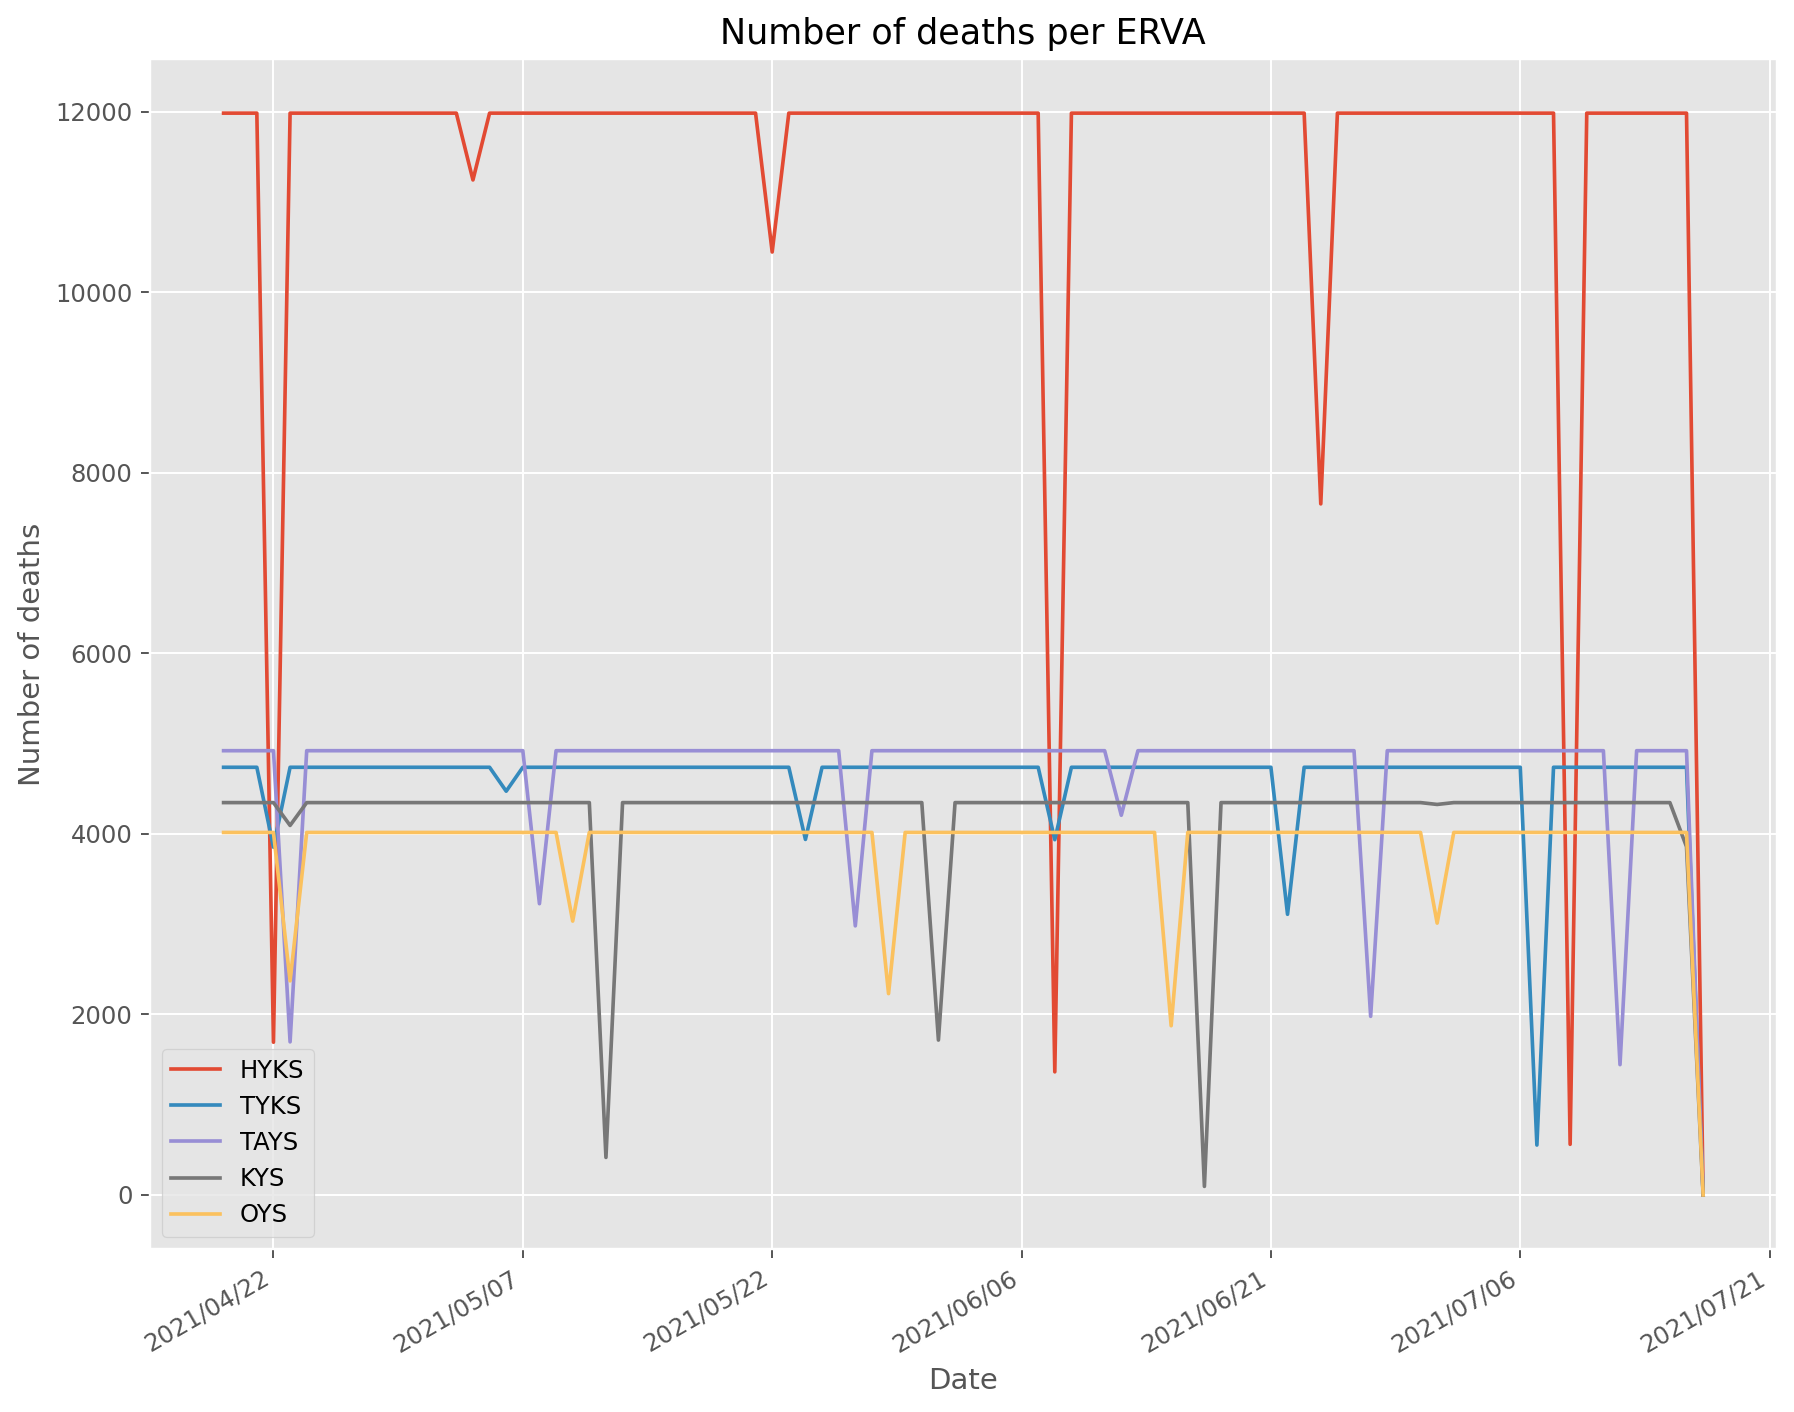

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=u_g_plot, t0=t0, T=T, ervas_labels=ervas_labels)

fig.autofmt_xdate()

In [11]:
T = 90
# transmission parameter
beta = 0.02
u = 30000
plot_interval = 15
t0 = '2021-04-19'
ervas_labels = ['HYKS', 'TYKS', 'TAYS', 'KYS', 'OYS']
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
policy_thl = True

Sg, Svg, Sxg, Lg, D_d, D_g_thl, u_g_thl = forward_integration(u, mob_av, beta, beta_gh, T, pop_erva_hat, age_er, t0, policy_thl)

age_er_prop = age_er.T
age_er_prop = age_er_prop[:, :, np.newaxis]
D_g_thl_plot = D_g_thl*age_er_prop
u_g_thl_plot = u_g_thl*age_er_prop

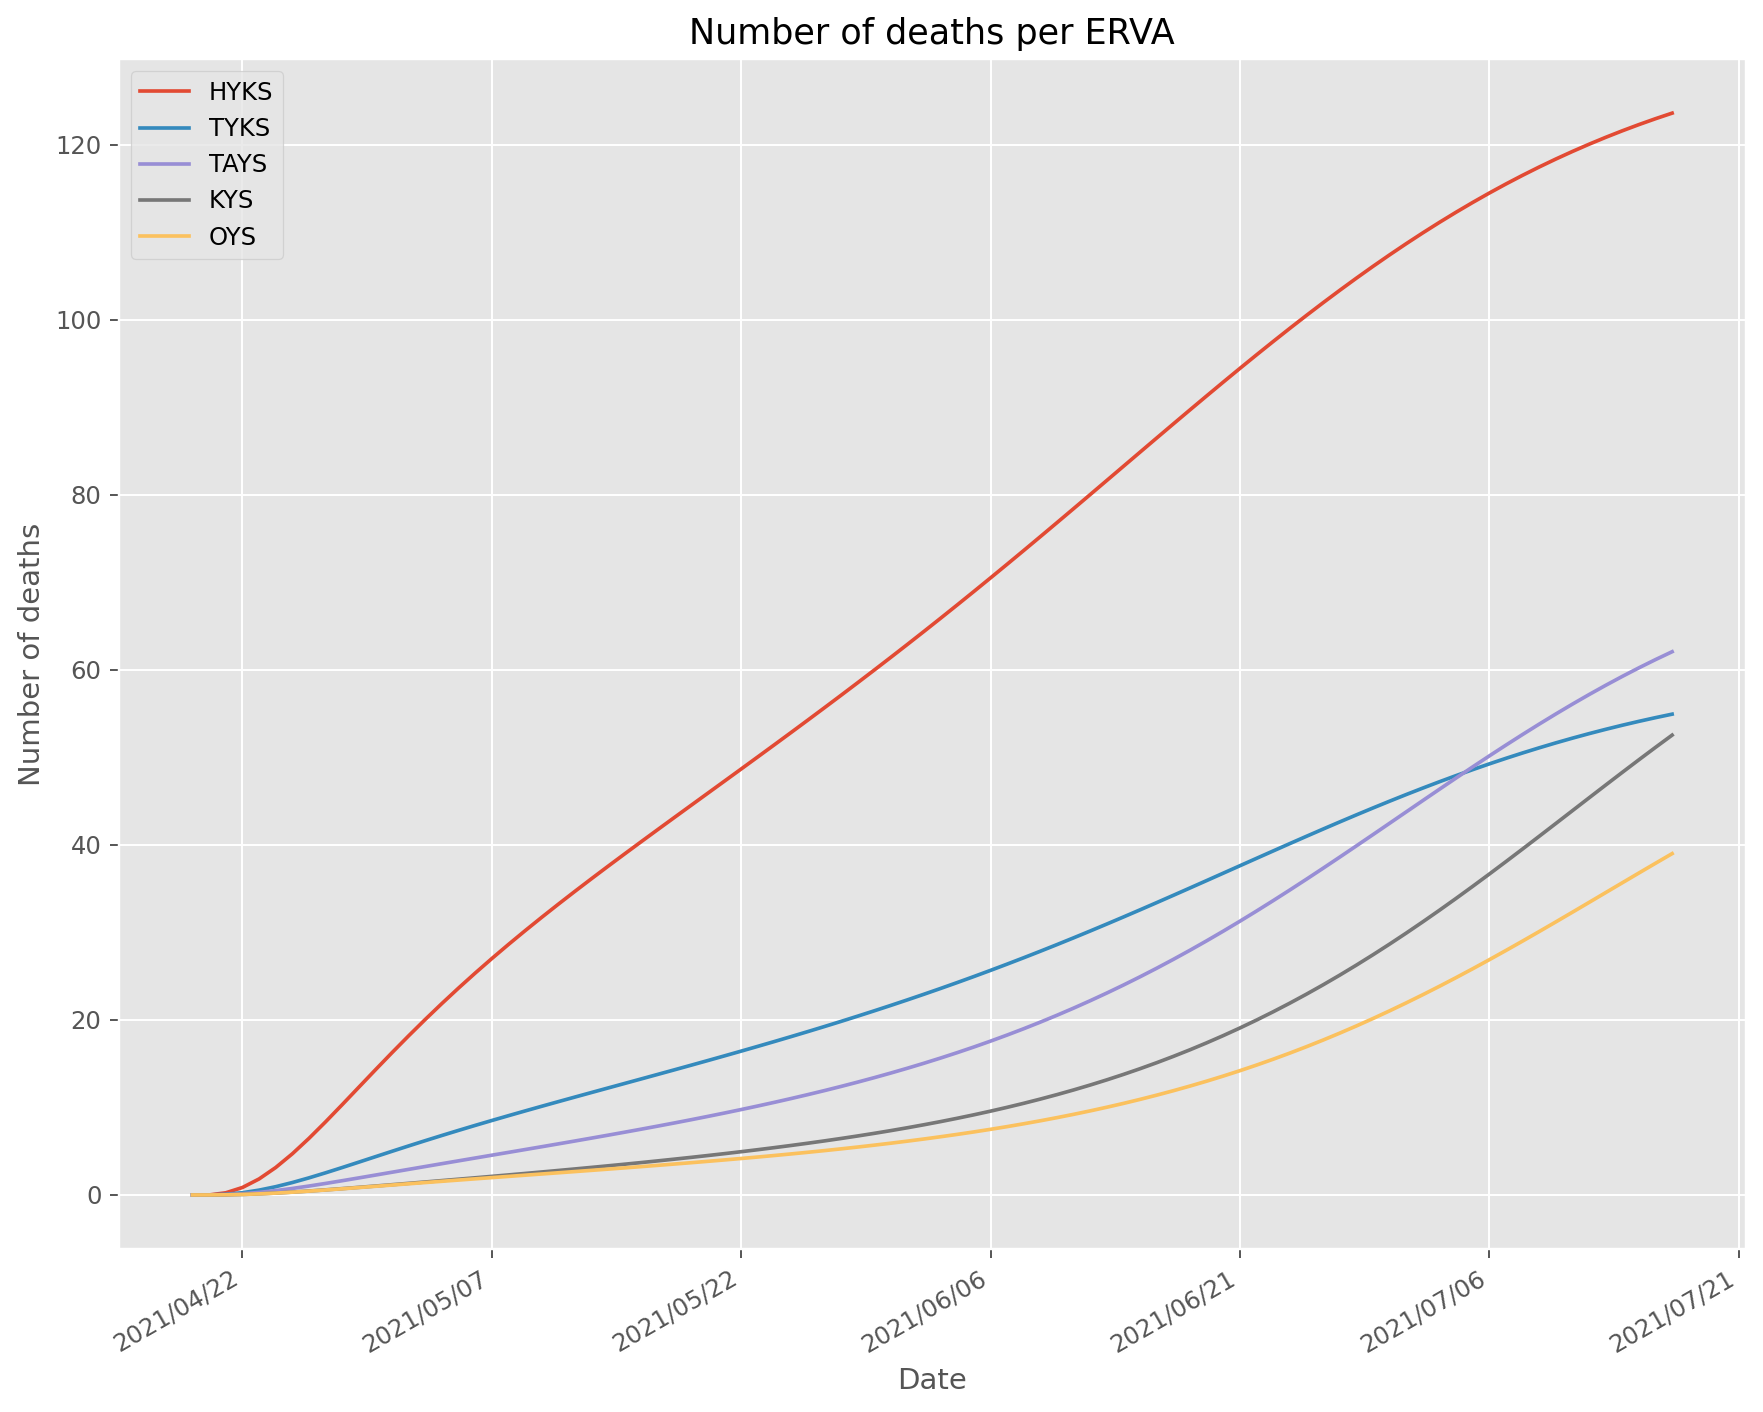

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=D_g_thl_plot, t0=t0, T=T, ervas_labels=ervas_labels)

fig.autofmt_xdate()

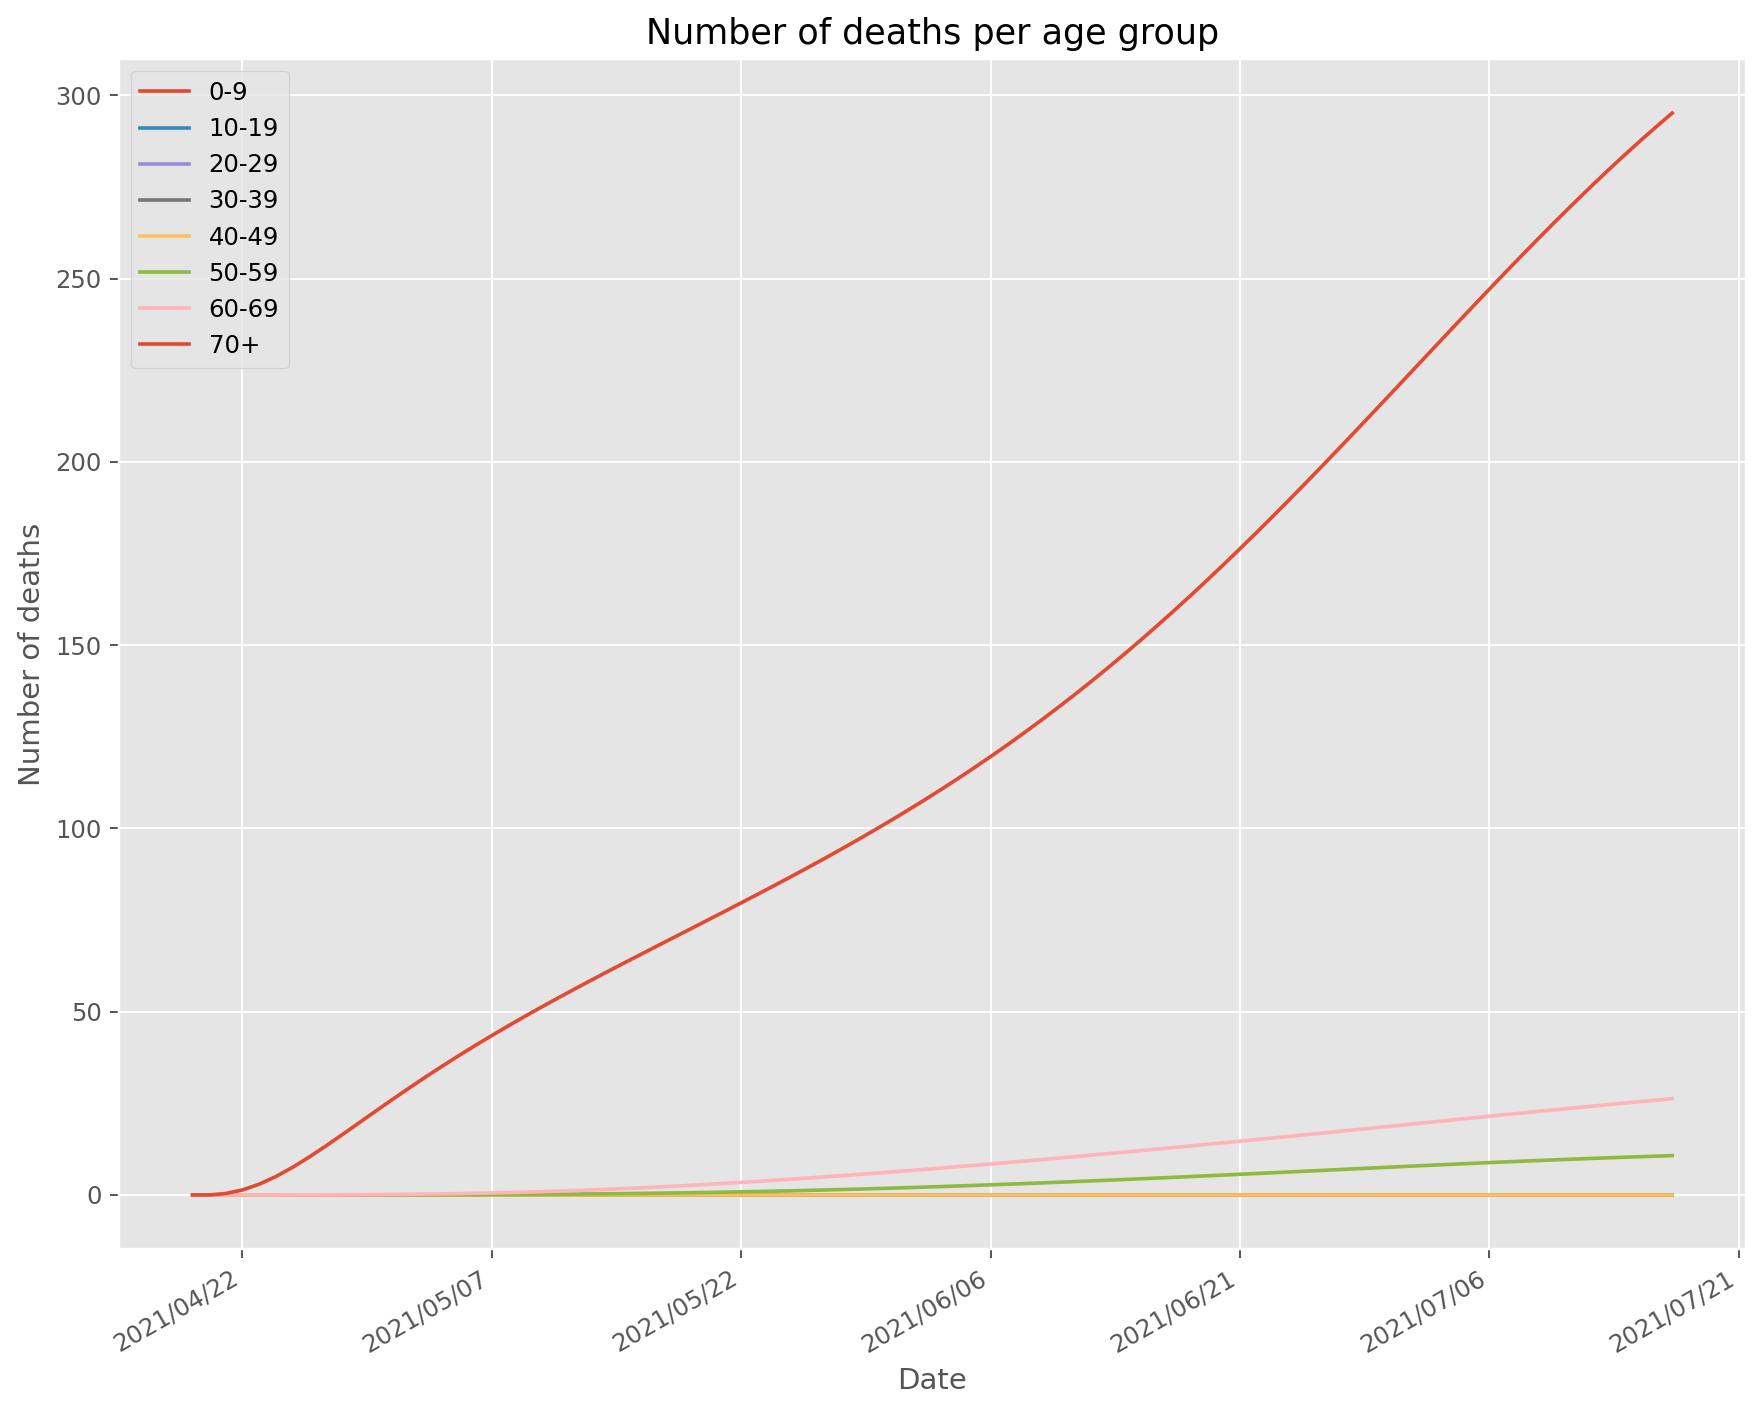

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=D_g_thl_plot, t0=t0, T=T, age_labels=age_labels)

fig.autofmt_xdate()

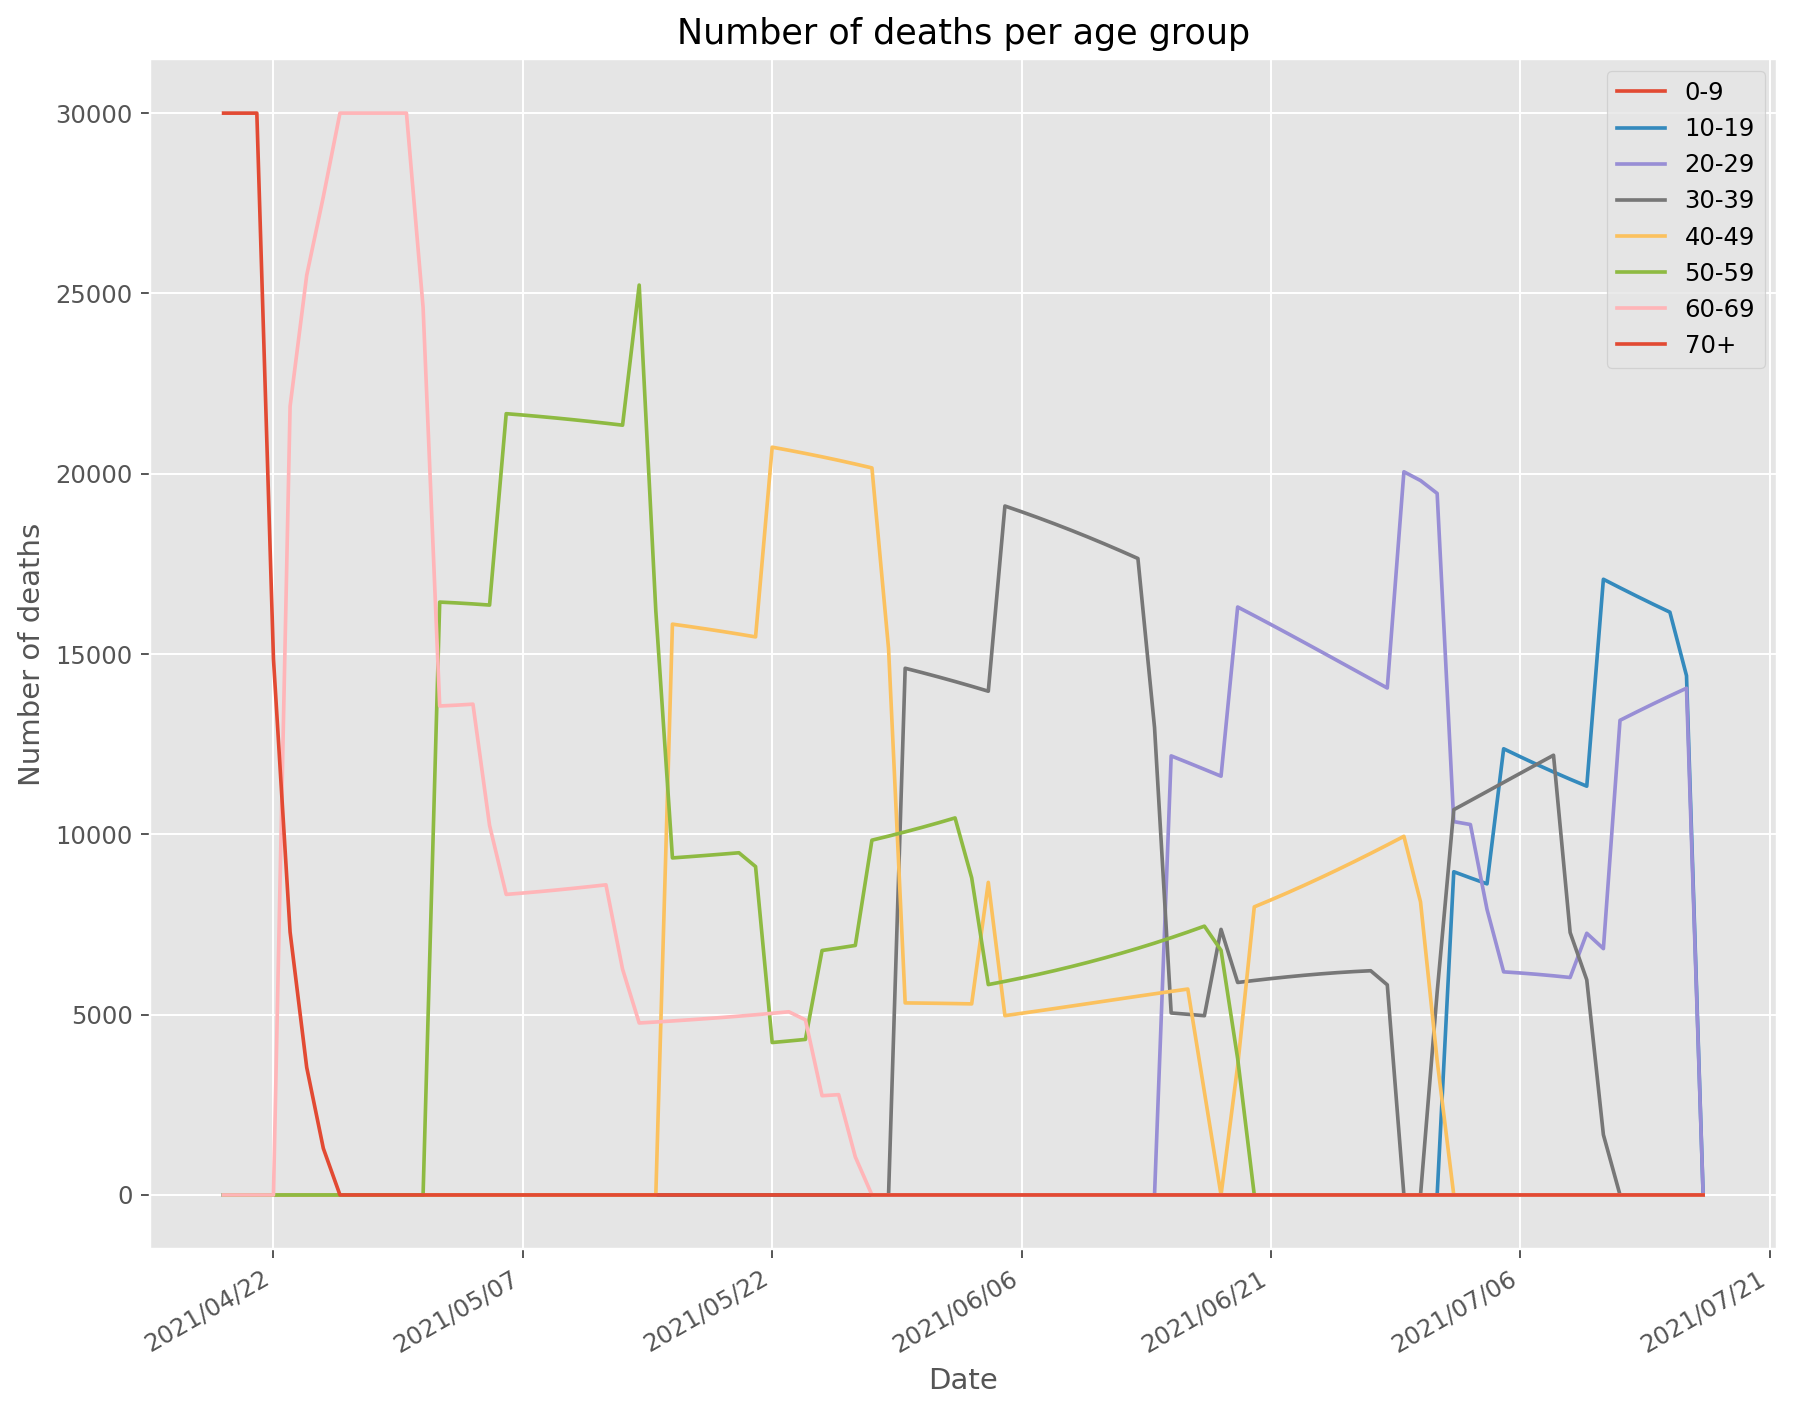

In [14]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=u_g_thl_plot, t0=t0, T=T, age_labels=age_labels)

fig.autofmt_xdate()

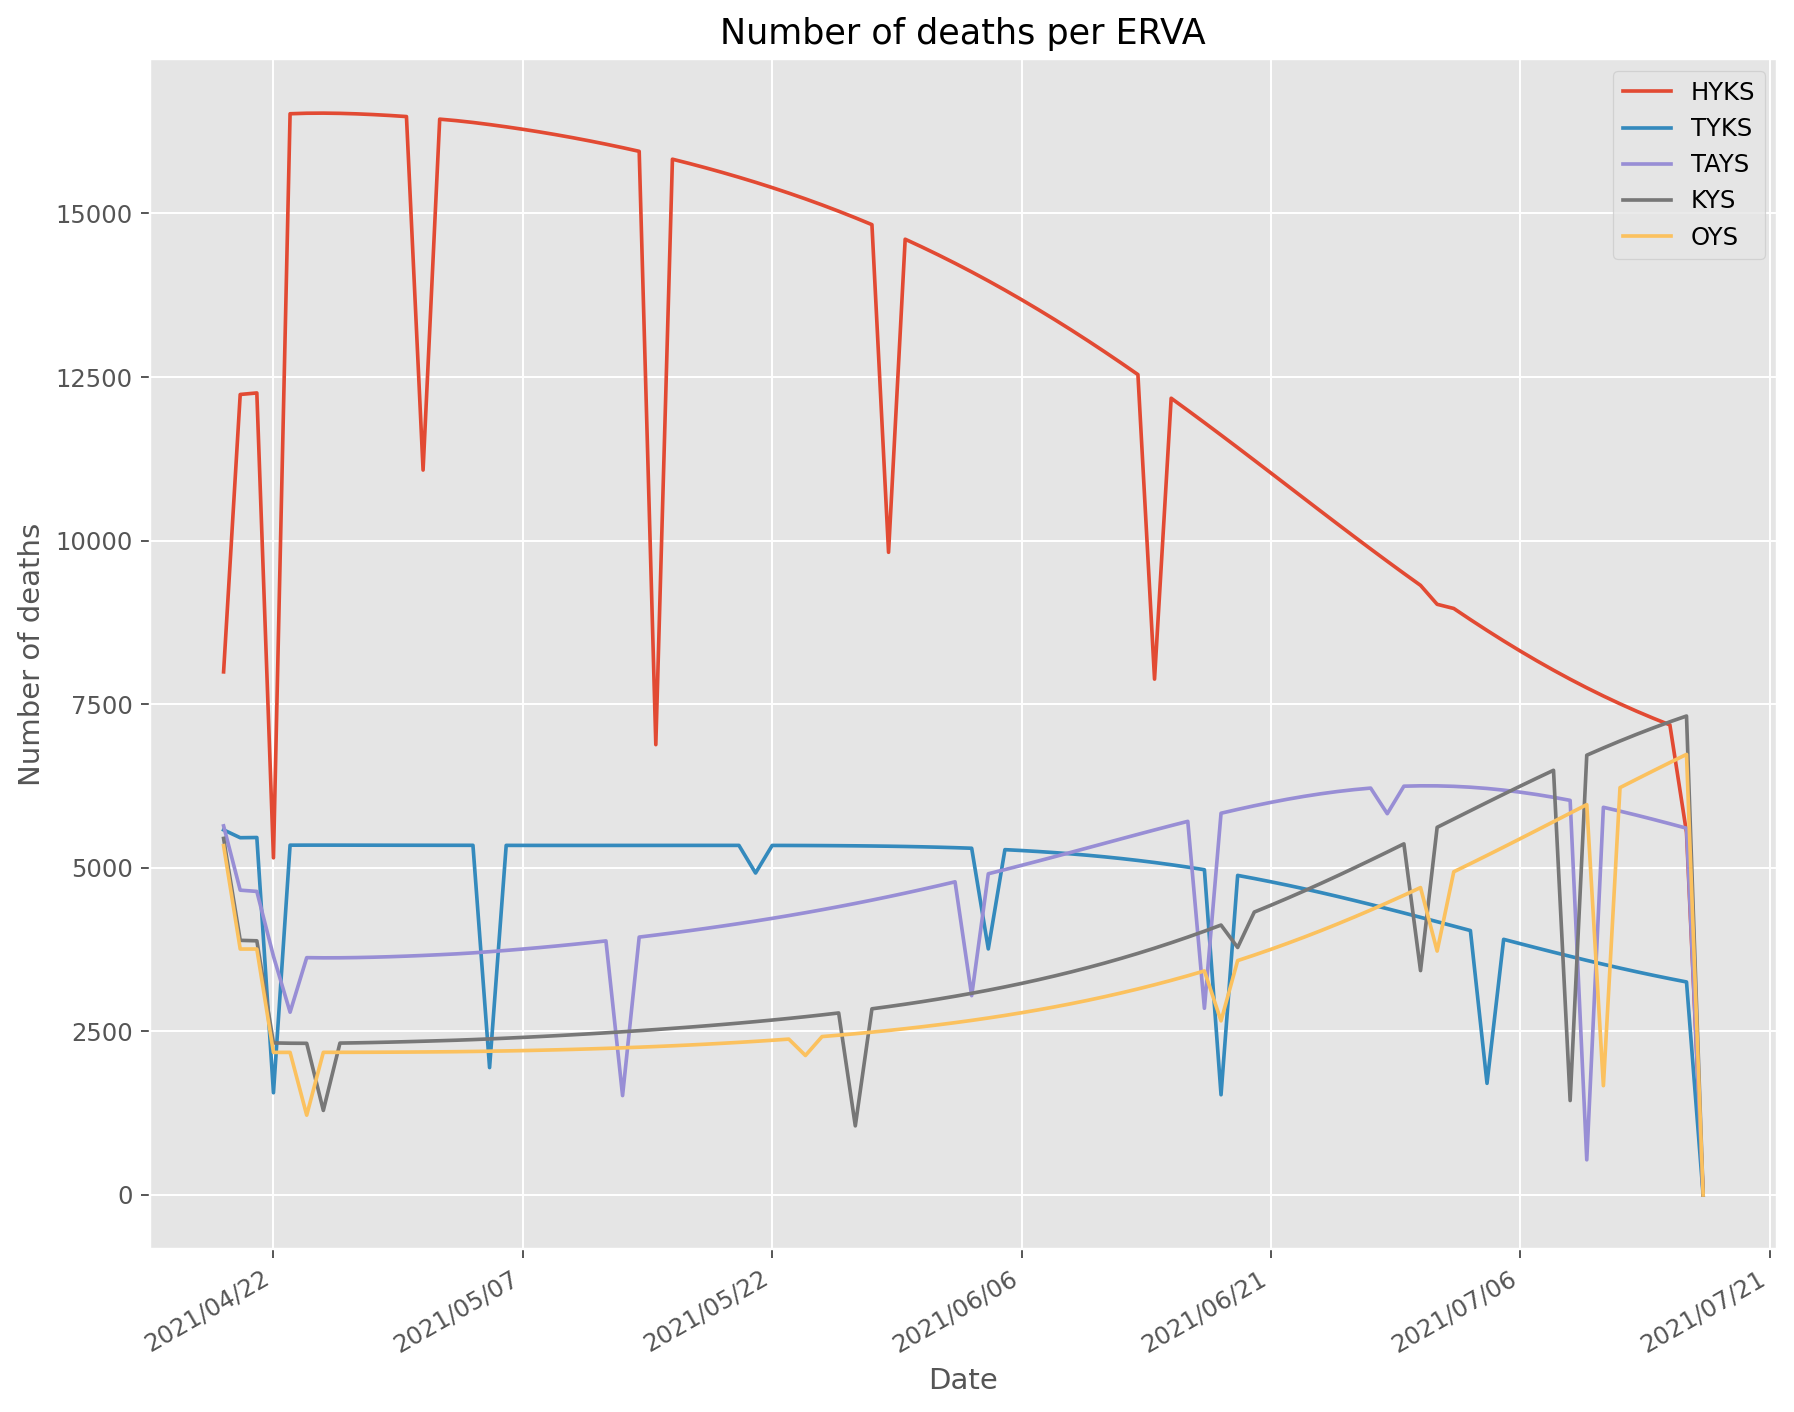

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=u_g_thl_plot, t0=t0, T=T, ervas_labels=ervas_labels)

fig.autofmt_xdate()

In [16]:
def plot_compare_strategies(ax, D_g, D_g_thl, t0, T):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    
    num_ages, num_ervas, days = D_g.shape
    assert num_ages == len(age_labels)
    
    x = [begin + datetime.timedelta(days=day) for day in range(T)]
    deaths = D_g.sum(axis=1)
    deaths = deaths.sum(axis=0)
    deaths_thl = D_g_thl.sum(axis=1)
    deaths_thl = deaths_thl.sum(axis=0)
    assert deaths.shape == deaths_thl.shape
    assert deaths.shape[0] == T
    
    ax.plot(x, deaths, label='Number of vaccines proportional to population')
    ax.plot(x, deaths_thl, label='THL strategy. Weighted sum')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of deaths')
    ax.set_title('Comparing vaccination strategies')
        
    ax.legend()

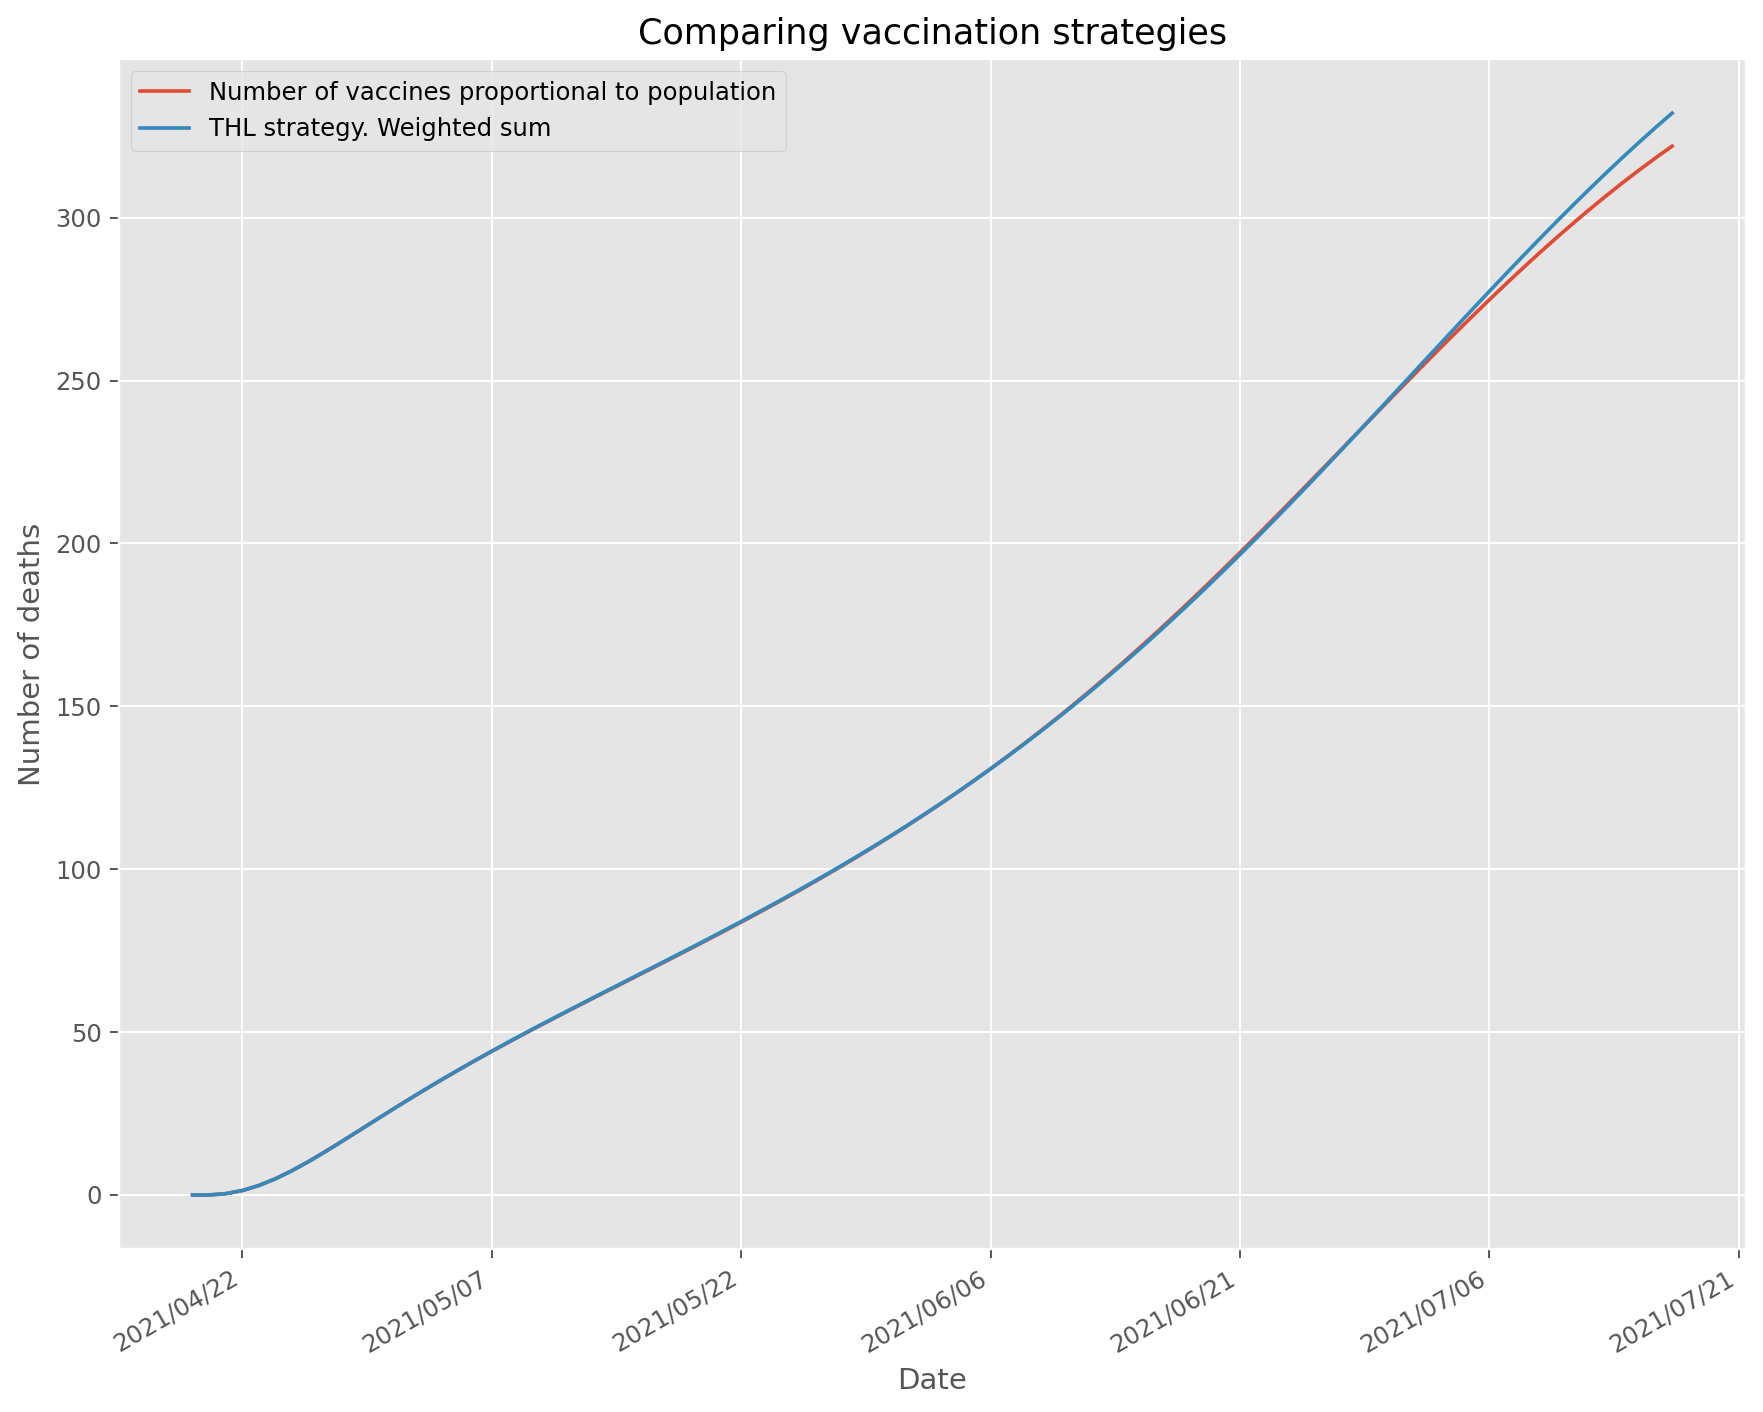

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_compare_strategies(ax=ax, D_g=D_g_plot, D_g_thl=D_g_thl_plot, t0=t0, T=T)

fig.autofmt_xdate()